# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = SeparableConv2DKeras(filters=filters, kernel_size=3, strides=1,
                             padding='same', activation='relu')(input_layer)
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    output = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output = layers.concatenate([output, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # Input
    # 256 x 256 x 3
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    
    x1 = encoder_block(inputs, 32, 2)
    # 128 x 128 x 32
    x2 = encoder_block(x1, 64, 2)
    # 64 x 64 x 64
    x3 = encoder_block(x2, 128, 2)
    # 32 x 32 x 128
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    x4 = conv2d_batchnorm(x3, 256, kernel_size=1, strides=1)
    # 32 x 32 x 256
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x5 = decoder_block(x4, x2, 128)
    # 64 x 64 x 128
    x6 = decoder_block(x5, x1, 64)
    # 128 x 128 x 64
    x = decoder_block(x6, inputs, 32)
    # 256 x 256 x 32
    
      
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
for split in ['train', 'validation']:
    split_dir = '../data/' + split + '/images'
    print('{} has {} images.'.format(split, len(os.listdir(split_dir))))

train has 4131 images.
validation has 1184 images.


In [9]:
from keras.callbacks import *

Using TensorFlow backend.


In [9]:
learning_rate = 0.01
batch_size = 32
num_epochs = 200
steps_per_epoch = 50
validation_steps = 37
workers = 2

In [10]:
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
separable_conv2d_keras_1 (Se (None, 256, 256, 32)      155       
_________________________________________________________________
separable_conv2d_keras_2 (Se (None, 128, 128, 32)      1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
separable_conv2d_keras_3 (Se (None, 128, 128, 64)      2400      
_________________________________________________________________
separable_conv2d_keras_4 (Se (None, 64, 64, 64)        4736      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
__________

In [13]:
# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

In [ ]:
logger_cb = plotting_tools.LoggerPlotter()
ckpt_cb = ModelCheckpoint('../data/weights/weights.{val_loss:.4f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True)
early_cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, verbose=0, mode='auto')
callbacks = [logger_cb, ckpt_cb]

Epoch 1/200
49/50 [============================>.] - ETA: 2s - loss: 0.3260

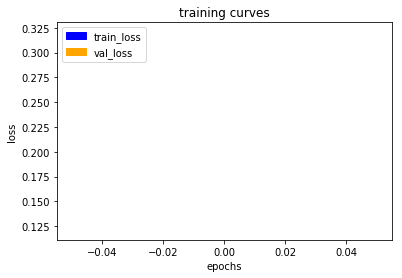

50/50 [==============================] - 122s - loss: 0.3205 - val_loss: 0.1212
Epoch 2/200
49/50 [============================>.] - ETA: 1s - loss: 0.0513

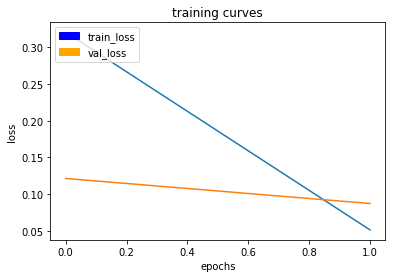

50/50 [==============================] - 80s - loss: 0.0512 - val_loss: 0.0872
Epoch 3/200
49/50 [============================>.] - ETA: 1s - loss: 0.0599

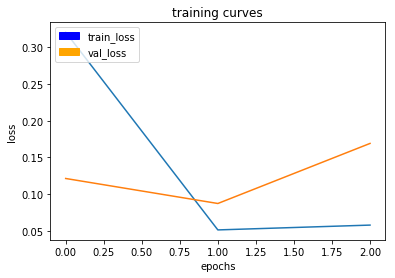

50/50 [==============================] - 79s - loss: 0.0600 - val_loss: 0.1690
Epoch 4/200
49/50 [============================>.] - ETA: 1s - loss: 0.0541

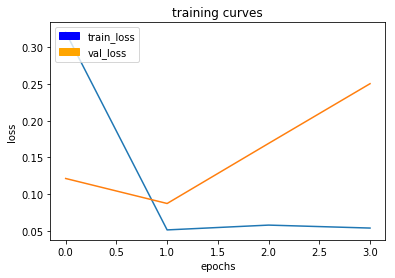

50/50 [==============================] - 79s - loss: 0.0537 - val_loss: 0.2504
Epoch 5/200
49/50 [============================>.] - ETA: 1s - loss: 0.0409

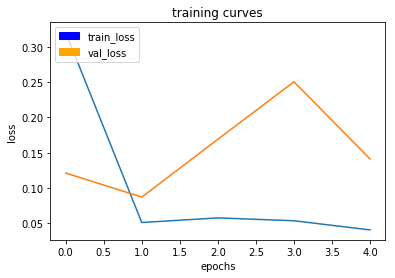

50/50 [==============================] - 80s - loss: 0.0407 - val_loss: 0.1412
Epoch 6/200
49/50 [============================>.] - ETA: 1s - loss: 0.0374

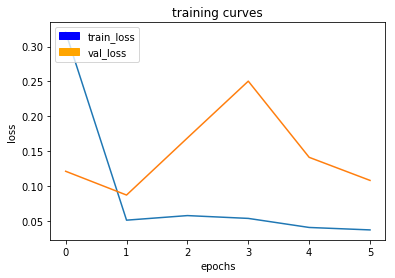

50/50 [==============================] - 79s - loss: 0.0373 - val_loss: 0.1081
Epoch 7/200
49/50 [============================>.] - ETA: 1s - loss: 0.0361

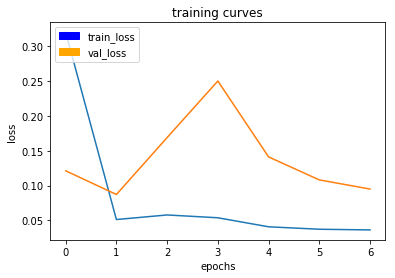

50/50 [==============================] - 79s - loss: 0.0362 - val_loss: 0.0950
Epoch 8/200
49/50 [============================>.] - ETA: 1s - loss: 0.0378

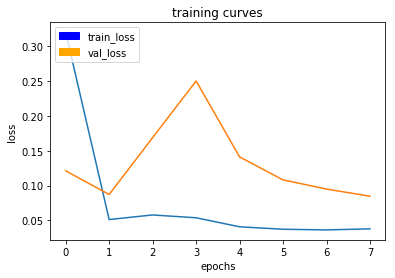

50/50 [==============================] - 78s - loss: 0.0375 - val_loss: 0.0846
Epoch 9/200
49/50 [============================>.] - ETA: 1s - loss: 0.0341

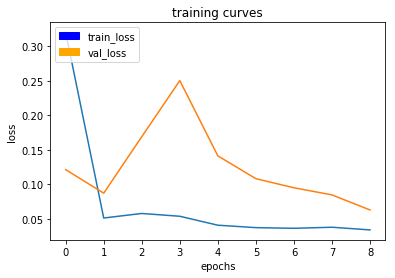

50/50 [==============================] - 80s - loss: 0.0339 - val_loss: 0.0628
Epoch 10/200
49/50 [============================>.] - ETA: 1s - loss: 0.0329

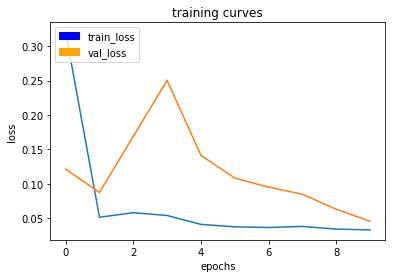

50/50 [==============================] - 80s - loss: 0.0327 - val_loss: 0.0453
Epoch 11/200
49/50 [============================>.] - ETA: 1s - loss: 0.0299

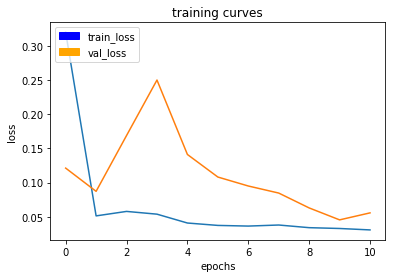

50/50 [==============================] - 78s - loss: 0.0303 - val_loss: 0.0556
Epoch 12/200
49/50 [============================>.] - ETA: 1s - loss: 0.0278

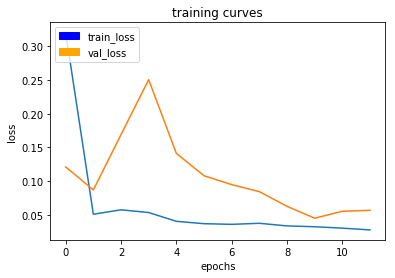

50/50 [==============================] - 80s - loss: 0.0280 - val_loss: 0.0569
Epoch 13/200
49/50 [============================>.] - ETA: 1s - loss: 0.0312

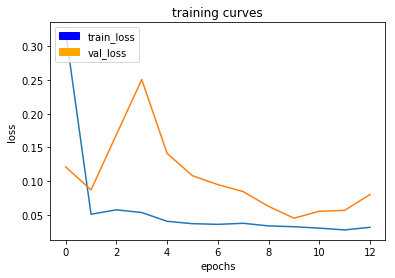

50/50 [==============================] - 78s - loss: 0.0318 - val_loss: 0.0804
Epoch 14/200
49/50 [============================>.] - ETA: 1s - loss: 0.0311

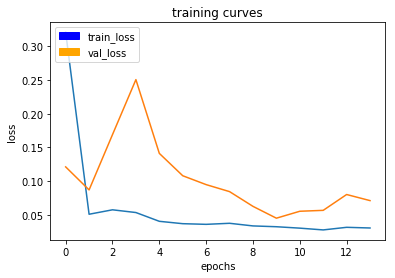

50/50 [==============================] - 80s - loss: 0.0308 - val_loss: 0.0713
Epoch 15/200
49/50 [============================>.] - ETA: 1s - loss: 0.0299

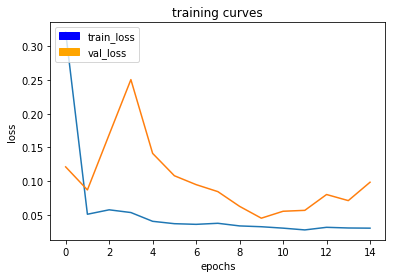

50/50 [==============================] - 80s - loss: 0.0306 - val_loss: 0.0985
Epoch 16/200
49/50 [============================>.] - ETA: 1s - loss: 0.0290

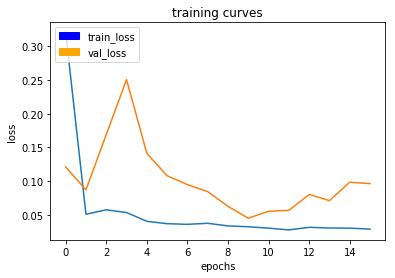

50/50 [==============================] - 79s - loss: 0.0290 - val_loss: 0.0966
Epoch 17/200
49/50 [============================>.] - ETA: 1s - loss: 0.0290

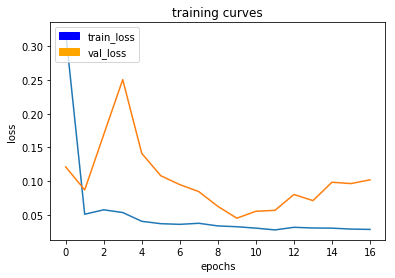

50/50 [==============================] - 80s - loss: 0.0287 - val_loss: 0.1021
Epoch 18/200
49/50 [============================>.] - ETA: 1s - loss: 0.0266

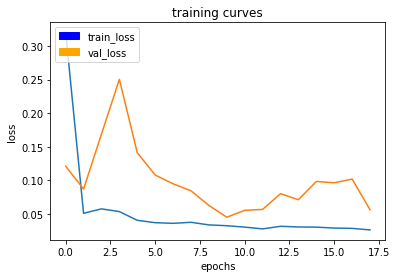

50/50 [==============================] - 80s - loss: 0.0264 - val_loss: 0.0564
Epoch 19/200
49/50 [============================>.] - ETA: 1s - loss: 0.0240

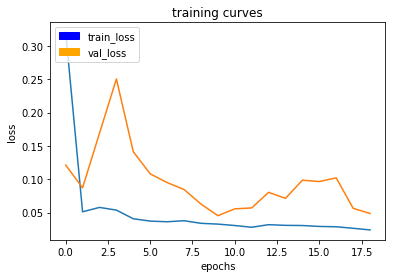

50/50 [==============================] - 78s - loss: 0.0240 - val_loss: 0.0486
Epoch 20/200
49/50 [============================>.] - ETA: 1s - loss: 0.0249

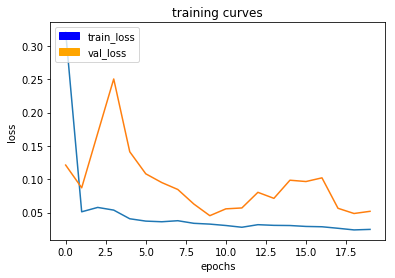

50/50 [==============================] - 80s - loss: 0.0248 - val_loss: 0.0519
Epoch 21/200
49/50 [============================>.] - ETA: 1s - loss: 0.0231

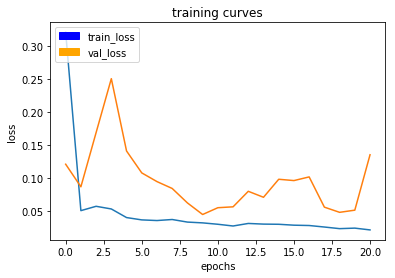

50/50 [==============================] - 79s - loss: 0.0229 - val_loss: 0.1355
Epoch 22/200
49/50 [============================>.] - ETA: 1s - loss: 0.0250

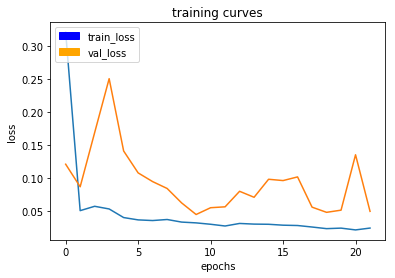

50/50 [==============================] - 80s - loss: 0.0249 - val_loss: 0.0501
Epoch 23/200
49/50 [============================>.] - ETA: 1s - loss: 0.0242

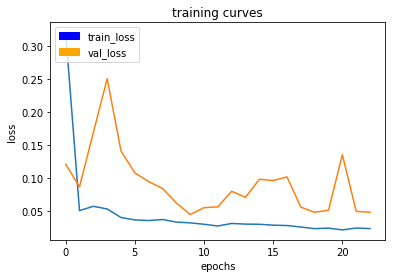

50/50 [==============================] - 79s - loss: 0.0241 - val_loss: 0.0488
Epoch 24/200
49/50 [============================>.] - ETA: 1s - loss: 0.0238

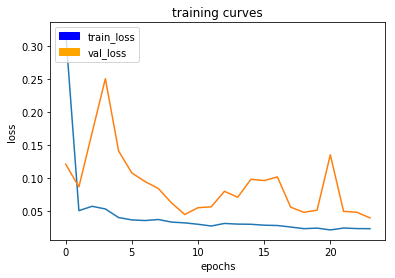

50/50 [==============================] - 78s - loss: 0.0237 - val_loss: 0.0402
Epoch 25/200
49/50 [============================>.] - ETA: 1s - loss: 0.0238

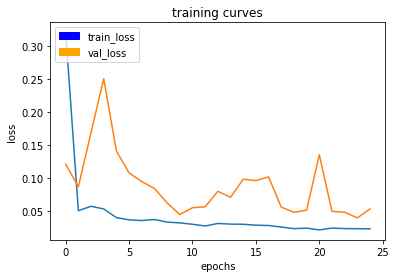

50/50 [==============================] - 79s - loss: 0.0237 - val_loss: 0.0539
Epoch 26/200
49/50 [============================>.] - ETA: 1s - loss: 0.0204

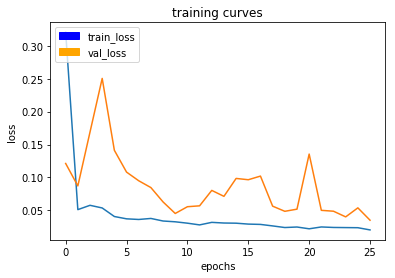

50/50 [==============================] - 78s - loss: 0.0203 - val_loss: 0.0351
Epoch 27/200
49/50 [============================>.] - ETA: 1s - loss: 0.0193

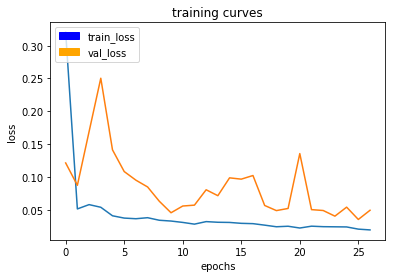

50/50 [==============================] - 80s - loss: 0.0192 - val_loss: 0.0491
Epoch 28/200
49/50 [============================>.] - ETA: 1s - loss: 0.0231

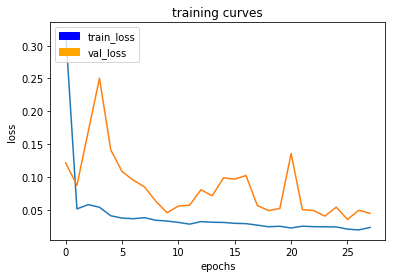

50/50 [==============================] - 80s - loss: 0.0229 - val_loss: 0.0445
Epoch 29/200
49/50 [============================>.] - ETA: 1s - loss: 0.0206

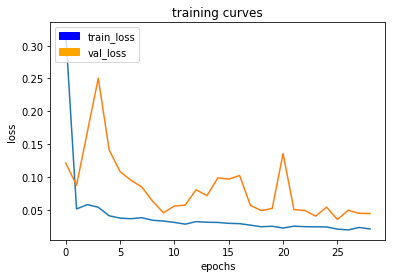

50/50 [==============================] - 78s - loss: 0.0205 - val_loss: 0.0441
Epoch 30/200
49/50 [============================>.] - ETA: 1s - loss: 0.0185

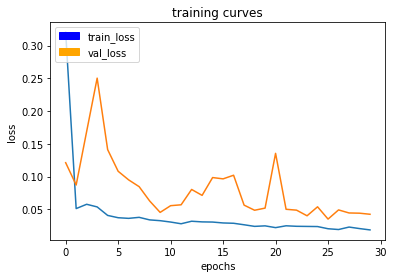

50/50 [==============================] - 80s - loss: 0.0186 - val_loss: 0.0425
Epoch 31/200
49/50 [============================>.] - ETA: 1s - loss: 0.0211

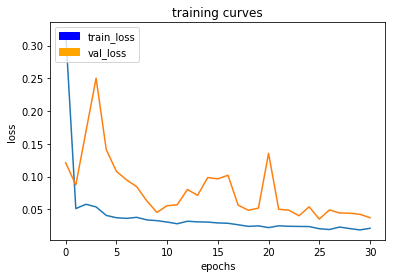

50/50 [==============================] - 79s - loss: 0.0211 - val_loss: 0.0372
Epoch 32/200
49/50 [============================>.] - ETA: 1s - loss: 0.0209

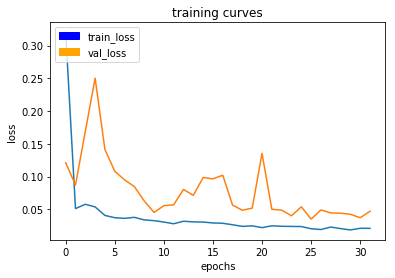

50/50 [==============================] - 78s - loss: 0.0208 - val_loss: 0.0471
Epoch 33/200
49/50 [============================>.] - ETA: 1s - loss: 0.0187

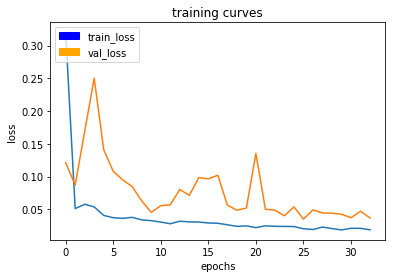

50/50 [==============================] - 79s - loss: 0.0188 - val_loss: 0.0369
Epoch 34/200
49/50 [============================>.] - ETA: 1s - loss: 0.0208

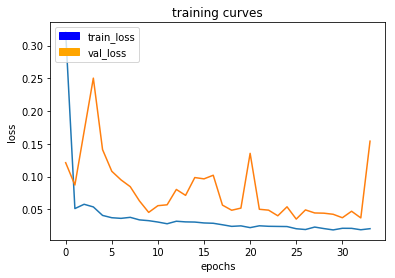

50/50 [==============================] - 78s - loss: 0.0208 - val_loss: 0.1541
Epoch 35/200
49/50 [============================>.] - ETA: 1s - loss: 0.0243

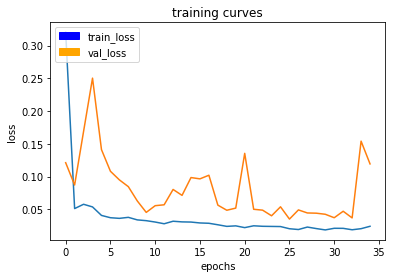

50/50 [==============================] - 80s - loss: 0.0241 - val_loss: 0.1194
Epoch 36/200
49/50 [============================>.] - ETA: 1s - loss: 0.0229

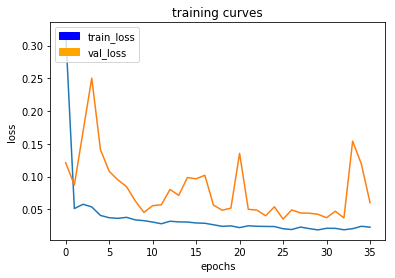

50/50 [==============================] - 80s - loss: 0.0228 - val_loss: 0.0602
Epoch 37/200
49/50 [============================>.] - ETA: 1s - loss: 0.0204

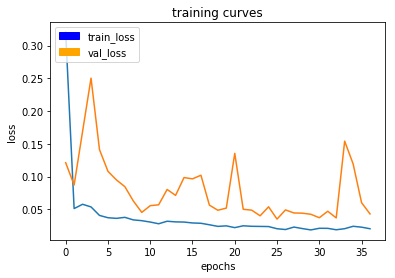

50/50 [==============================] - 78s - loss: 0.0202 - val_loss: 0.0430
Epoch 38/200
49/50 [============================>.] - ETA: 1s - loss: 0.0180

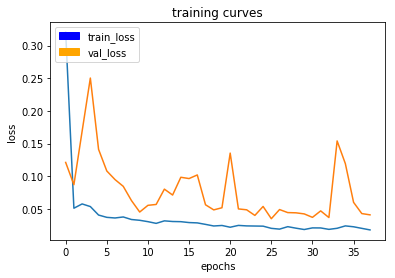

50/50 [==============================] - 80s - loss: 0.0180 - val_loss: 0.0410
Epoch 39/200
49/50 [============================>.] - ETA: 1s - loss: 0.0210

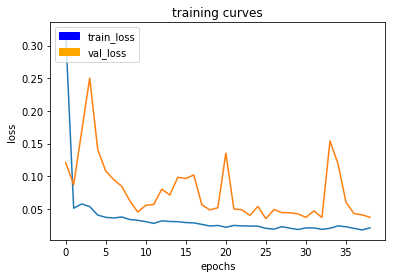

50/50 [==============================] - 79s - loss: 0.0210 - val_loss: 0.0373
Epoch 40/200
49/50 [============================>.] - ETA: 1s - loss: 0.0188

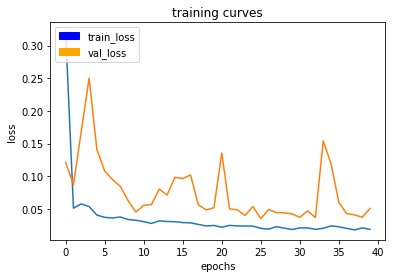

50/50 [==============================] - 79s - loss: 0.0188 - val_loss: 0.0509
Epoch 41/200
49/50 [============================>.] - ETA: 1s - loss: 0.0226

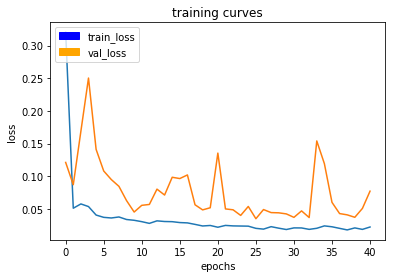

50/50 [==============================] - 80s - loss: 0.0224 - val_loss: 0.0773
Epoch 42/200
49/50 [============================>.] - ETA: 1s - loss: 0.0187

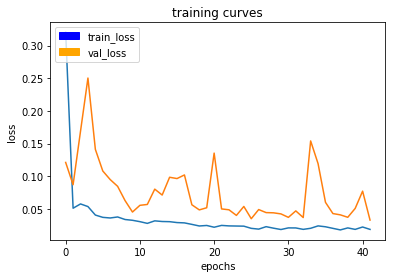

50/50 [==============================] - 79s - loss: 0.0186 - val_loss: 0.0330
Epoch 43/200
49/50 [============================>.] - ETA: 1s - loss: 0.0244

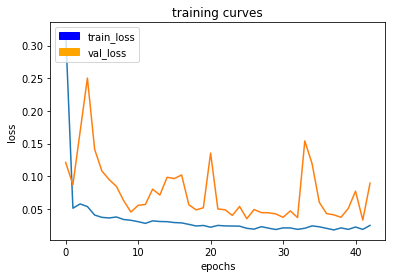

50/50 [==============================] - 80s - loss: 0.0249 - val_loss: 0.0895
Epoch 44/200
49/50 [============================>.] - ETA: 1s - loss: 0.0192

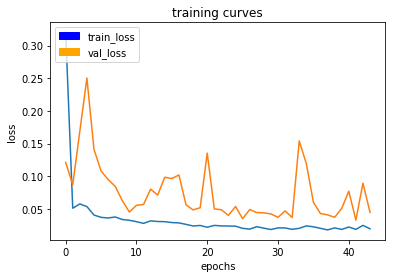

50/50 [==============================] - 80s - loss: 0.0196 - val_loss: 0.0448
Epoch 45/200
49/50 [============================>.] - ETA: 1s - loss: 0.0208

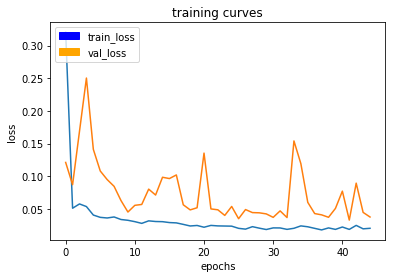

50/50 [==============================] - 79s - loss: 0.0207 - val_loss: 0.0377
Epoch 46/200
49/50 [============================>.] - ETA: 1s - loss: 0.0204

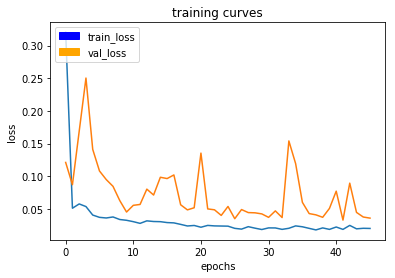

50/50 [==============================] - 79s - loss: 0.0202 - val_loss: 0.0360
Epoch 47/200
49/50 [============================>.] - ETA: 1s - loss: 0.0224

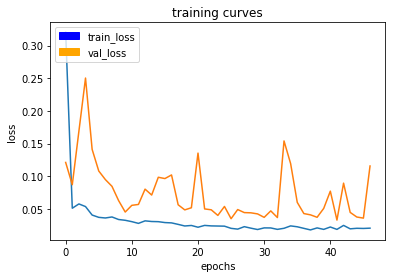

50/50 [==============================] - 78s - loss: 0.0224 - val_loss: 0.1158
Epoch 48/200
49/50 [============================>.] - ETA: 1s - loss: 0.0258

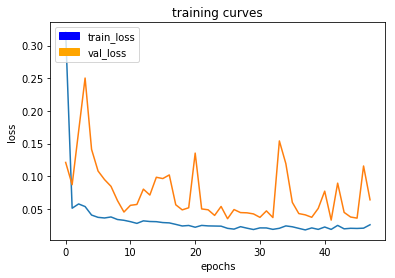

50/50 [==============================] - 79s - loss: 0.0259 - val_loss: 0.0640
Epoch 49/200
49/50 [============================>.] - ETA: 1s - loss: 0.0195

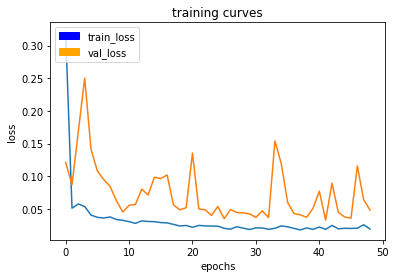

50/50 [==============================] - 80s - loss: 0.0194 - val_loss: 0.0483
Epoch 50/200
49/50 [============================>.] - ETA: 1s - loss: 0.0170

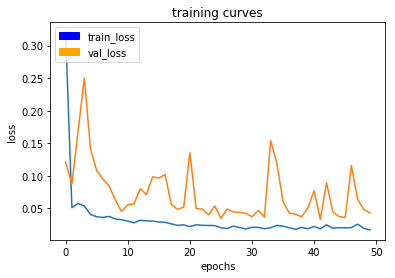

50/50 [==============================] - 78s - loss: 0.0169 - val_loss: 0.0431
Epoch 51/200
49/50 [============================>.] - ETA: 1s - loss: 0.0161

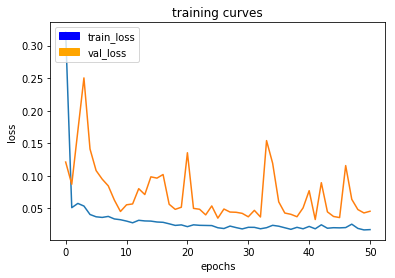

50/50 [==============================] - 79s - loss: 0.0175 - val_loss: 0.0457
Epoch 52/200
49/50 [============================>.] - ETA: 1s - loss: 0.0161

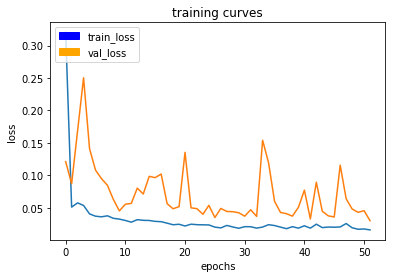

50/50 [==============================] - 79s - loss: 0.0159 - val_loss: 0.0302
Epoch 53/200
49/50 [============================>.] - ETA: 1s - loss: 0.0153

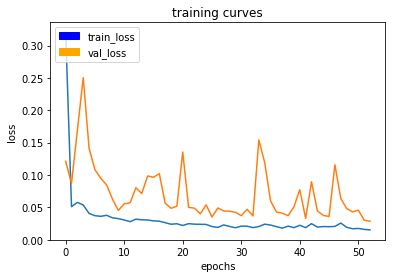

50/50 [==============================] - 80s - loss: 0.0152 - val_loss: 0.0287
Epoch 54/200
49/50 [============================>.] - ETA: 1s - loss: 0.0163

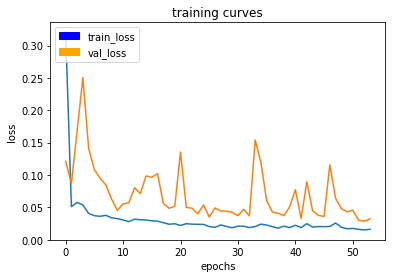

50/50 [==============================] - 79s - loss: 0.0162 - val_loss: 0.0322
Epoch 55/200
49/50 [============================>.] - ETA: 1s - loss: 0.0142

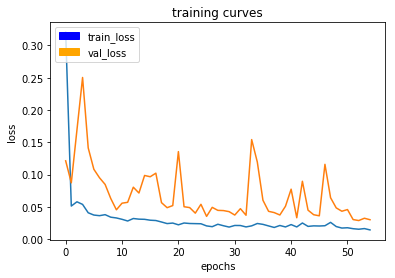

50/50 [==============================] - 78s - loss: 0.0141 - val_loss: 0.0300
Epoch 56/200
49/50 [============================>.] - ETA: 1s - loss: 0.0182

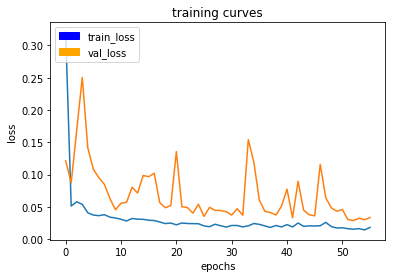

50/50 [==============================] - 79s - loss: 0.0181 - val_loss: 0.0333
Epoch 57/200
49/50 [============================>.] - ETA: 1s - loss: 0.0145

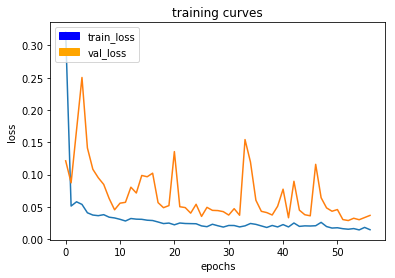

50/50 [==============================] - 80s - loss: 0.0145 - val_loss: 0.0367
Epoch 58/200
49/50 [============================>.] - ETA: 1s - loss: 0.0185

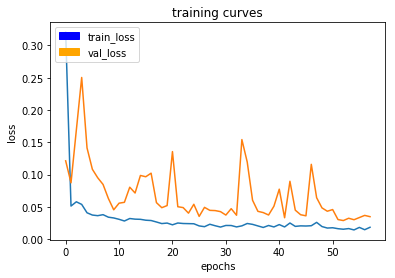

50/50 [==============================] - 78s - loss: 0.0185 - val_loss: 0.0347
Epoch 59/200
49/50 [============================>.] - ETA: 1s - loss: 0.0151

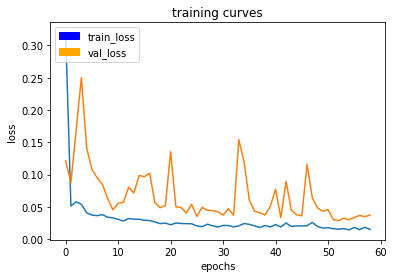

50/50 [==============================] - 79s - loss: 0.0151 - val_loss: 0.0371
Epoch 60/200
49/50 [============================>.] - ETA: 1s - loss: 0.0141

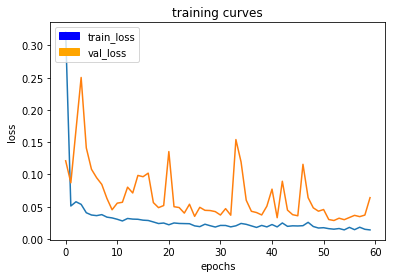

50/50 [==============================] - 78s - loss: 0.0140 - val_loss: 0.0641
Epoch 61/200
49/50 [============================>.] - ETA: 1s - loss: 0.0173

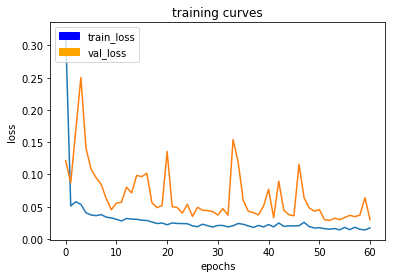

50/50 [==============================] - 80s - loss: 0.0173 - val_loss: 0.0301
Epoch 62/200
49/50 [============================>.] - ETA: 1s - loss: 0.0129

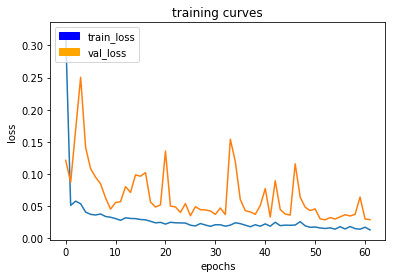

50/50 [==============================] - 80s - loss: 0.0130 - val_loss: 0.0289
Epoch 63/200
49/50 [============================>.] - ETA: 1s - loss: 0.0144

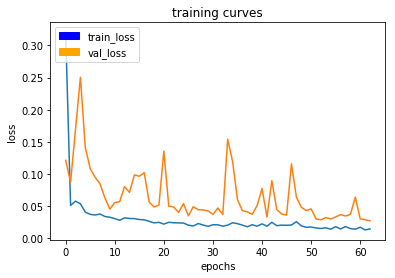

50/50 [==============================] - 78s - loss: 0.0144 - val_loss: 0.0271
Epoch 64/200
49/50 [============================>.] - ETA: 1s - loss: 0.0131

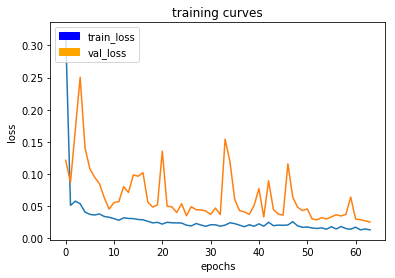

50/50 [==============================] - 79s - loss: 0.0130 - val_loss: 0.0252
Epoch 65/200
49/50 [============================>.] - ETA: 1s - loss: 0.0157

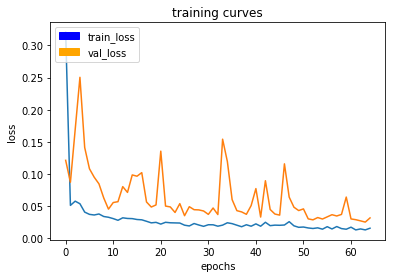

50/50 [==============================] - 78s - loss: 0.0155 - val_loss: 0.0317
Epoch 66/200
49/50 [============================>.] - ETA: 1s - loss: 0.0143

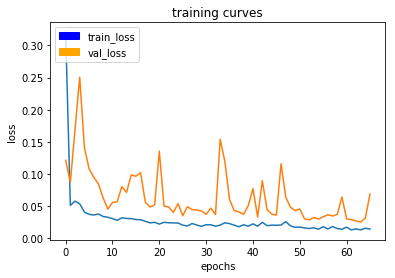

50/50 [==============================] - 80s - loss: 0.0143 - val_loss: 0.0689
Epoch 67/200
49/50 [============================>.] - ETA: 1s - loss: 0.0174

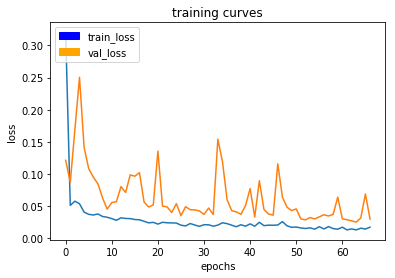

50/50 [==============================] - 80s - loss: 0.0173 - val_loss: 0.0299
Epoch 68/200
49/50 [============================>.] - ETA: 1s - loss: 0.0135

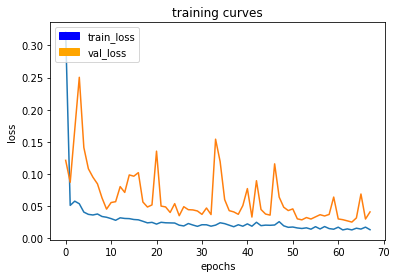

50/50 [==============================] - 78s - loss: 0.0134 - val_loss: 0.0410
Epoch 69/200
49/50 [============================>.] - ETA: 1s - loss: 0.0152

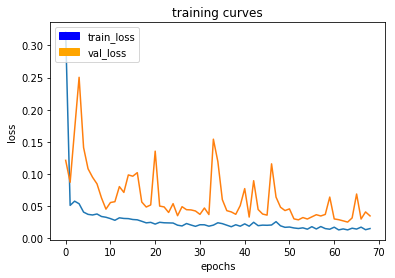

50/50 [==============================] - 79s - loss: 0.0151 - val_loss: 0.0348
Epoch 70/200
49/50 [============================>.] - ETA: 1s - loss: 0.0157

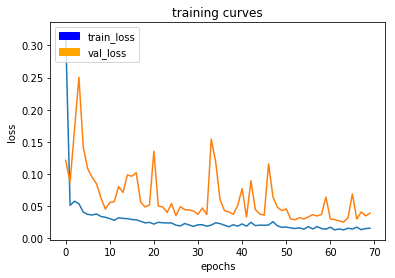

50/50 [==============================] - 80s - loss: 0.0156 - val_loss: 0.0391
Epoch 71/200
49/50 [============================>.] - ETA: 1s - loss: 0.0131

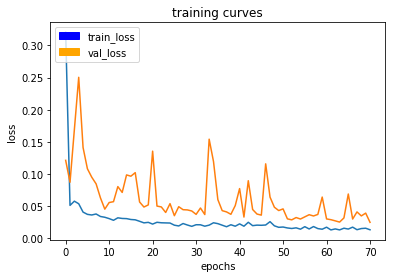

50/50 [==============================] - 79s - loss: 0.0131 - val_loss: 0.0248
Epoch 72/200
49/50 [============================>.] - ETA: 1s - loss: 0.0147

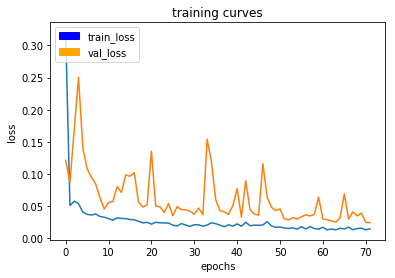

50/50 [==============================] - 79s - loss: 0.0146 - val_loss: 0.0245
Epoch 73/200
49/50 [============================>.] - ETA: 1s - loss: 0.0130

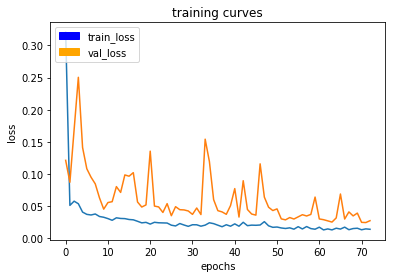

50/50 [==============================] - 78s - loss: 0.0139 - val_loss: 0.0274
Epoch 74/200
49/50 [============================>.] - ETA: 1s - loss: 0.0133

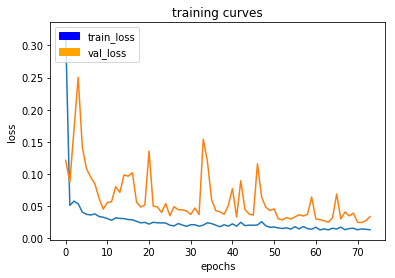

50/50 [==============================] - 80s - loss: 0.0133 - val_loss: 0.0338
Epoch 75/200
49/50 [============================>.] - ETA: 1s - loss: 0.0115

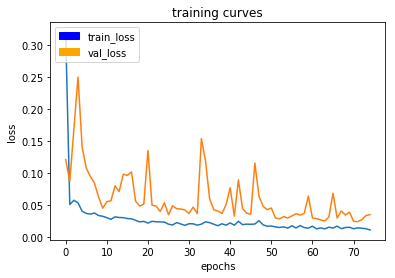

50/50 [==============================] - 80s - loss: 0.0114 - val_loss: 0.0354
Epoch 76/200
49/50 [============================>.] - ETA: 1s - loss: 0.0110

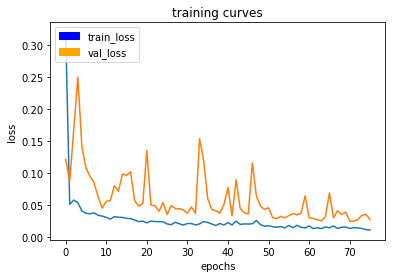

50/50 [==============================] - 78s - loss: 0.0110 - val_loss: 0.0273
Epoch 77/200
49/50 [============================>.] - ETA: 1s - loss: 0.0118

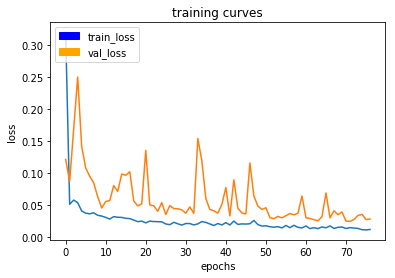

50/50 [==============================] - 79s - loss: 0.0117 - val_loss: 0.0281
Epoch 78/200
49/50 [============================>.] - ETA: 1s - loss: 0.0152

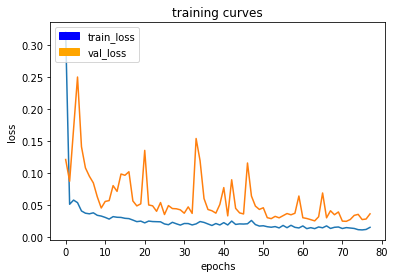

50/50 [==============================] - 78s - loss: 0.0151 - val_loss: 0.0362
Epoch 79/200
49/50 [============================>.] - ETA: 1s - loss: 0.0141

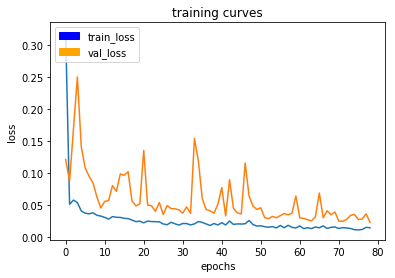

50/50 [==============================] - 80s - loss: 0.0143 - val_loss: 0.0229
Epoch 80/200
49/50 [============================>.] - ETA: 1s - loss: 0.0128

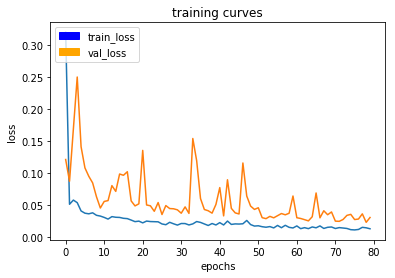

50/50 [==============================] - 79s - loss: 0.0128 - val_loss: 0.0305
Epoch 81/200
49/50 [============================>.] - ETA: 1s - loss: 0.0138

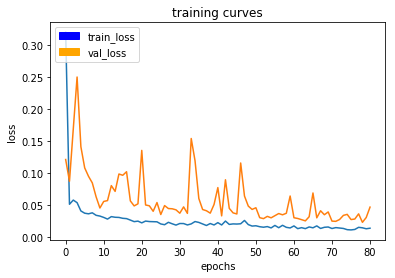

50/50 [==============================] - 78s - loss: 0.0137 - val_loss: 0.0467
Epoch 82/200
49/50 [============================>.] - ETA: 1s - loss: 0.0184

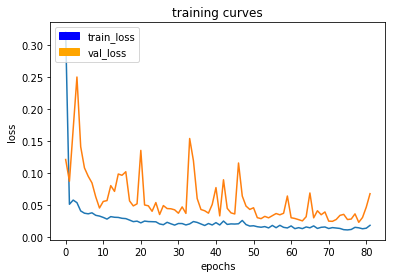

50/50 [==============================] - 80s - loss: 0.0182 - val_loss: 0.0677
Epoch 83/200
49/50 [============================>.] - ETA: 1s - loss: 0.0127

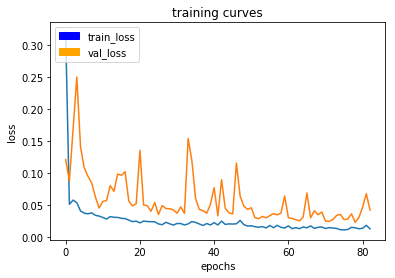

50/50 [==============================] - 79s - loss: 0.0127 - val_loss: 0.0420
Epoch 84/200
49/50 [============================>.] - ETA: 1s - loss: 0.0131

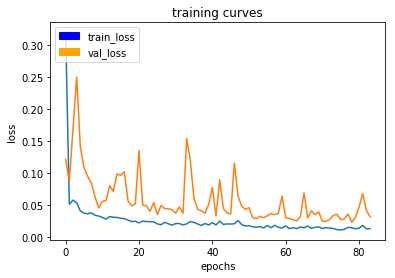

50/50 [==============================] - 78s - loss: 0.0130 - val_loss: 0.0316
Epoch 85/200
49/50 [============================>.] - ETA: 1s - loss: 0.0149

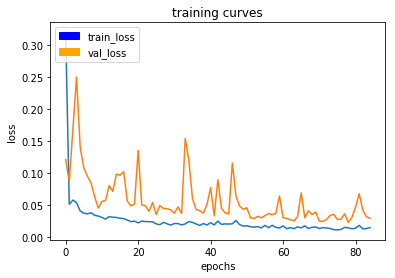

50/50 [==============================] - 79s - loss: 0.0147 - val_loss: 0.0291
Epoch 86/200
49/50 [============================>.] - ETA: 1s - loss: 0.0135

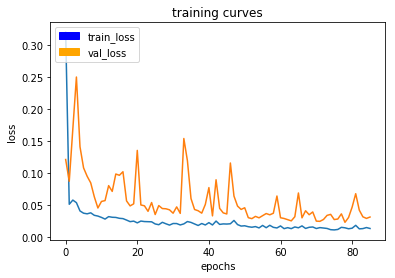

50/50 [==============================] - 78s - loss: 0.0133 - val_loss: 0.0312
Epoch 87/200
49/50 [============================>.] - ETA: 1s - loss: 0.0138

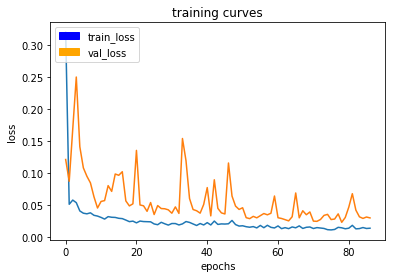

50/50 [==============================] - 79s - loss: 0.0137 - val_loss: 0.0298
Epoch 88/200
49/50 [============================>.] - ETA: 1s - loss: 0.0124

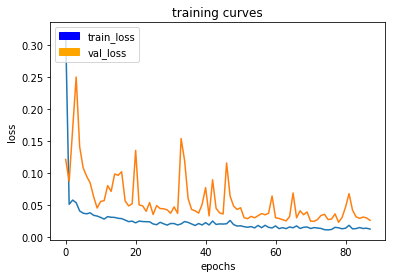

50/50 [==============================] - 79s - loss: 0.0124 - val_loss: 0.0261
Epoch 89/200
49/50 [============================>.] - ETA: 1s - loss: 0.0119

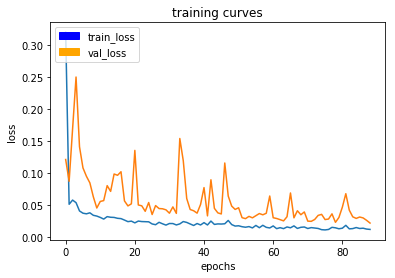

50/50 [==============================] - 78s - loss: 0.0118 - val_loss: 0.0218
Epoch 90/200
49/50 [============================>.] - ETA: 1s - loss: 0.0106

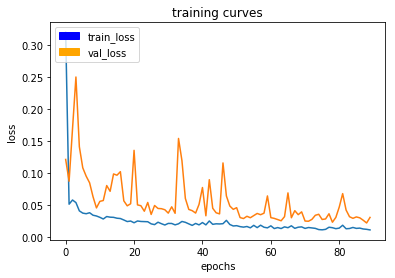

50/50 [==============================] - 79s - loss: 0.0109 - val_loss: 0.0305
Epoch 91/200
49/50 [============================>.] - ETA: 1s - loss: 0.0148

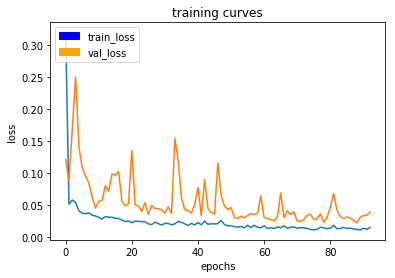

50/50 [==============================] - 80s - loss: 0.0148 - val_loss: 0.0390
Epoch 94/200
49/50 [============================>.] - ETA: 1s - loss: 0.0135

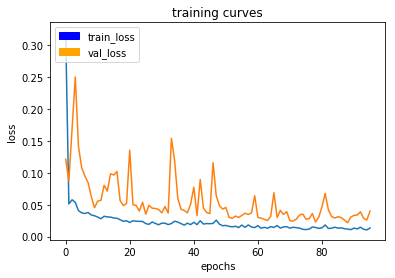

50/50 [==============================] - 80s - loss: 0.0136 - val_loss: 0.0399
Epoch 97/200
49/50 [============================>.] - ETA: 1s - loss: 0.0148

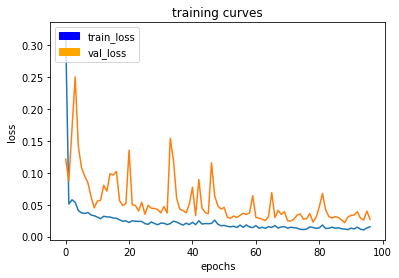

50/50 [==============================] - 78s - loss: 0.0151 - val_loss: 0.0273
Epoch 98/200
49/50 [============================>.] - ETA: 1s - loss: 0.0114

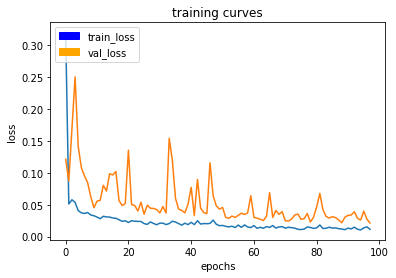

50/50 [==============================] - 79s - loss: 0.0113 - val_loss: 0.0213
Epoch 99/200
49/50 [============================>.] - ETA: 1s - loss: 0.0115

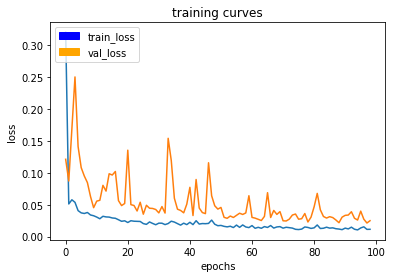

50/50 [==============================] - 78s - loss: 0.0115 - val_loss: 0.0249
Epoch 100/200
49/50 [============================>.] - ETA: 1s - loss: 0.0132

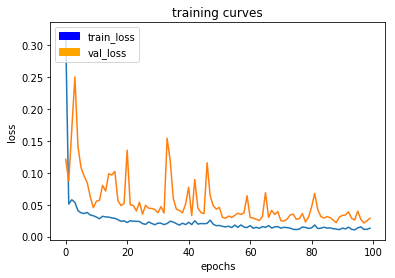

50/50 [==============================] - 80s - loss: 0.0132 - val_loss: 0.0289
Epoch 101/200
49/50 [============================>.] - ETA: 1s - loss: 0.0105

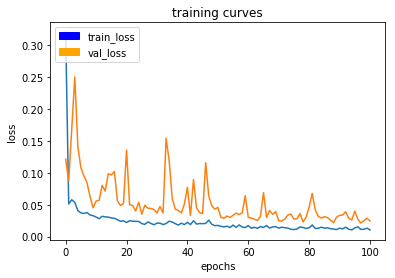

50/50 [==============================] - 80s - loss: 0.0104 - val_loss: 0.0245
Epoch 102/200
49/50 [============================>.] - ETA: 1s - loss: 0.0096

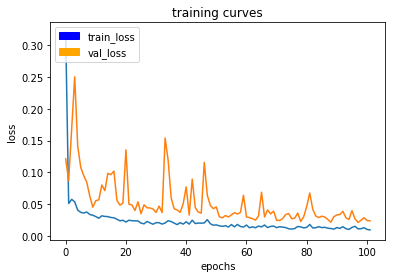

50/50 [==============================] - 78s - loss: 0.0097 - val_loss: 0.0239
Epoch 103/200
49/50 [============================>.] - ETA: 1s - loss: 0.0094

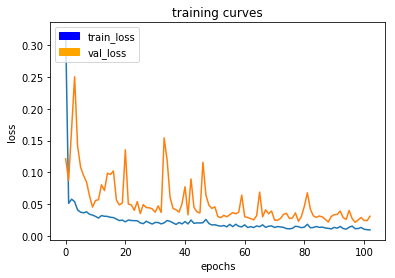

50/50 [==============================] - 80s - loss: 0.0093 - val_loss: 0.0309
Epoch 104/200
49/50 [============================>.] - ETA: 1s - loss: 0.0118

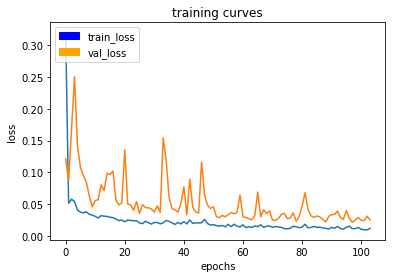

50/50 [==============================] - 78s - loss: 0.0117 - val_loss: 0.0251
Epoch 105/200
49/50 [============================>.] - ETA: 1s - loss: 0.0156

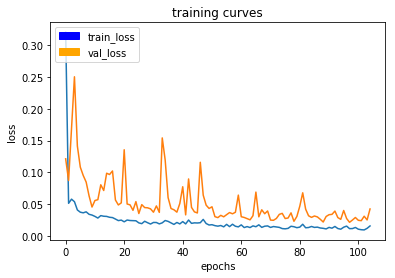

50/50 [==============================] - 79s - loss: 0.0155 - val_loss: 0.0423
Epoch 106/200
49/50 [============================>.] - ETA: 1s - loss: 0.0111

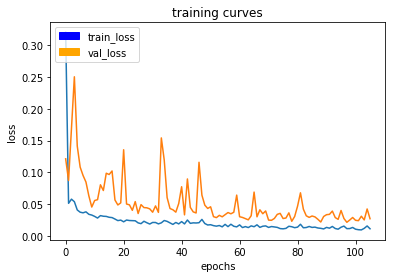

50/50 [==============================] - 80s - loss: 0.0111 - val_loss: 0.0269
Epoch 107/200
49/50 [============================>.] - ETA: 1s - loss: 0.0103

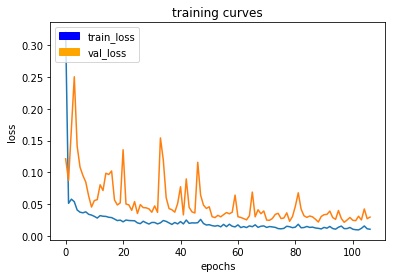

50/50 [==============================] - 78s - loss: 0.0103 - val_loss: 0.0295
Epoch 108/200
49/50 [============================>.] - ETA: 1s - loss: 0.0125

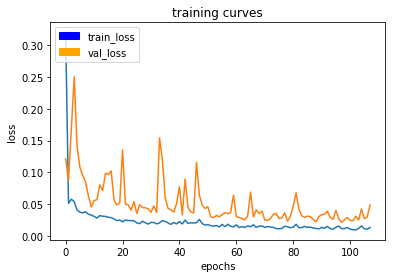

50/50 [==============================] - 79s - loss: 0.0130 - val_loss: 0.0485
Epoch 109/200
49/50 [============================>.] - ETA: 1s - loss: 0.0124

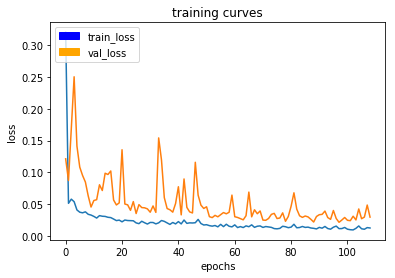

50/50 [==============================] - 80s - loss: 0.0123 - val_loss: 0.0294
Epoch 110/200
49/50 [============================>.] - ETA: 1s - loss: 0.0125

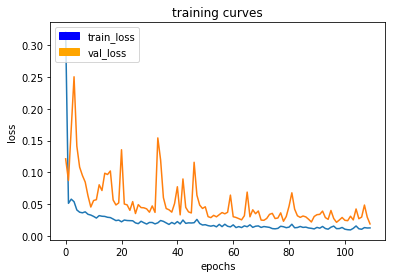

50/50 [==============================] - 78s - loss: 0.0124 - val_loss: 0.0187
Epoch 111/200
49/50 [============================>.] - ETA: 1s - loss: 0.0111

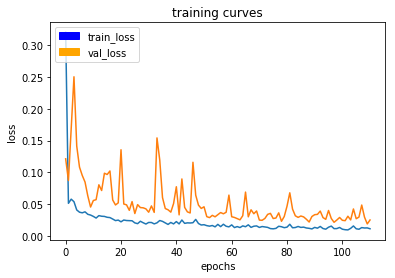

50/50 [==============================] - 79s - loss: 0.0111 - val_loss: 0.0250
Epoch 112/200
49/50 [============================>.] - ETA: 1s - loss: 0.0094

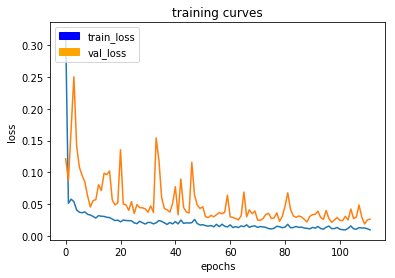

50/50 [==============================] - 78s - loss: 0.0094 - val_loss: 0.0264
Epoch 113/200
49/50 [============================>.] - ETA: 1s - loss: 0.0120

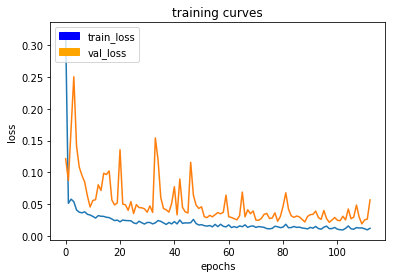

50/50 [==============================] - 80s - loss: 0.0119 - val_loss: 0.0566
Epoch 114/200
49/50 [============================>.] - ETA: 1s - loss: 0.0109

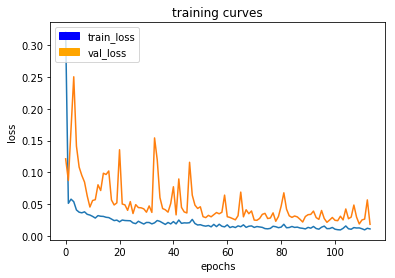

50/50 [==============================] - 80s - loss: 0.0109 - val_loss: 0.0181
Epoch 115/200
49/50 [============================>.] - ETA: 1s - loss: 0.0102

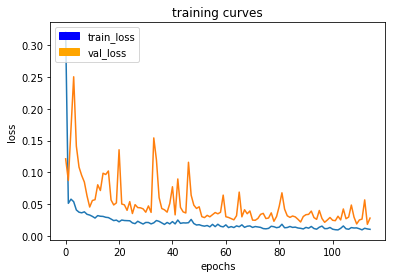

50/50 [==============================] - 78s - loss: 0.0102 - val_loss: 0.0279
Epoch 116/200
49/50 [============================>.] - ETA: 1s - loss: 0.0087

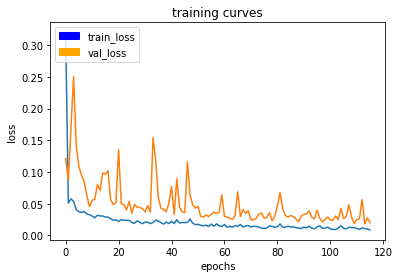

50/50 [==============================] - 79s - loss: 0.0087 - val_loss: 0.0200
Epoch 117/200
49/50 [============================>.] - ETA: 1s - loss: 0.0117

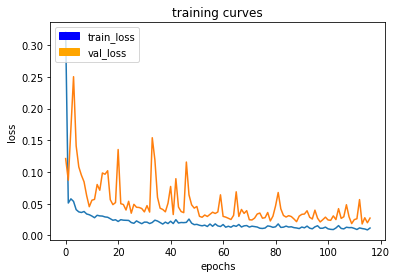

50/50 [==============================] - 78s - loss: 0.0118 - val_loss: 0.0274
Epoch 118/200
49/50 [============================>.] - ETA: 1s - loss: 0.0096

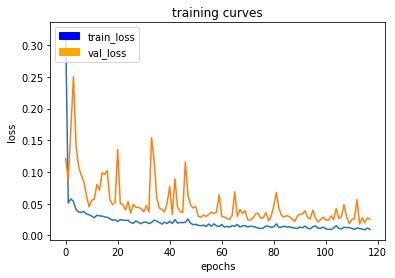

50/50 [==============================] - 80s - loss: 0.0096 - val_loss: 0.0254
Epoch 119/200
49/50 [============================>.] - ETA: 1s - loss: 0.0083

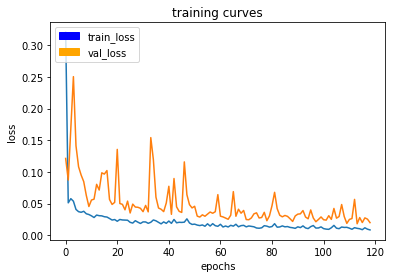

50/50 [==============================] - 80s - loss: 0.0084 - val_loss: 0.0199
Epoch 120/200
49/50 [============================>.] - ETA: 1s - loss: 0.0173

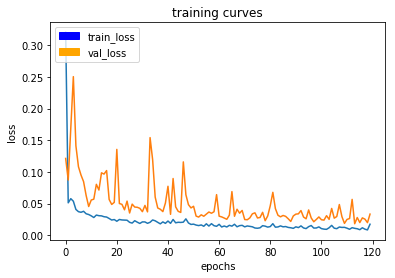

50/50 [==============================] - 78s - loss: 0.0172 - val_loss: 0.0333
Epoch 121/200
49/50 [============================>.] - ETA: 1s - loss: 0.0161

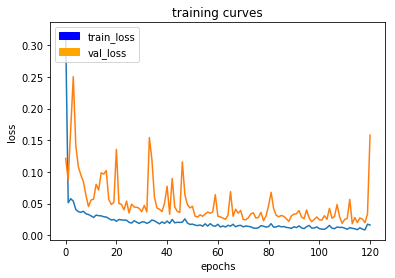

50/50 [==============================] - 79s - loss: 0.0161 - val_loss: 0.1580
Epoch 122/200
49/50 [============================>.] - ETA: 1s - loss: 0.0131

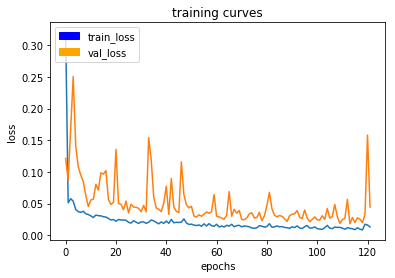

50/50 [==============================] - 80s - loss: 0.0130 - val_loss: 0.0445
Epoch 123/200
49/50 [============================>.] - ETA: 1s - loss: 0.0091

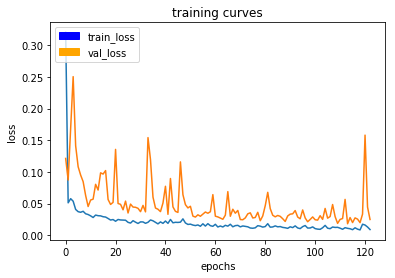

50/50 [==============================] - 78s - loss: 0.0091 - val_loss: 0.0249
Epoch 124/200
49/50 [============================>.] - ETA: 1s - loss: 0.0140

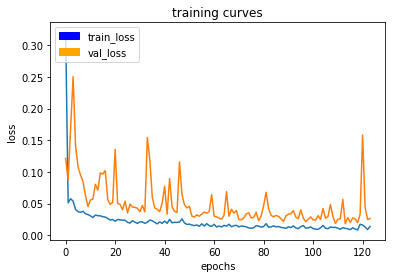

50/50 [==============================] - 80s - loss: 0.0139 - val_loss: 0.0263
Epoch 125/200
49/50 [============================>.] - ETA: 1s - loss: 0.0103

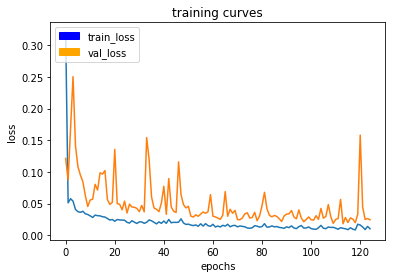

50/50 [==============================] - 78s - loss: 0.0102 - val_loss: 0.0243
Epoch 126/200
49/50 [============================>.] - ETA: 1s - loss: 0.0112

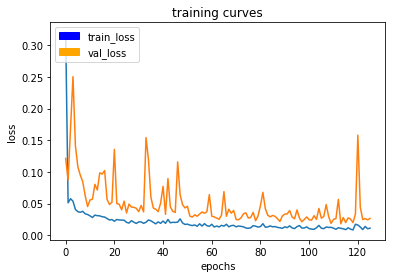

50/50 [==============================] - 80s - loss: 0.0112 - val_loss: 0.0265
Epoch 127/200
 3/50 [>.............................] - ETA: 62s - loss: 0.0125

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [22]:
# Save your trained model weights
weight_file_name = 'model_3e3d.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
model.load_weights('../data/weights/weights.0.0181.hdf5')

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

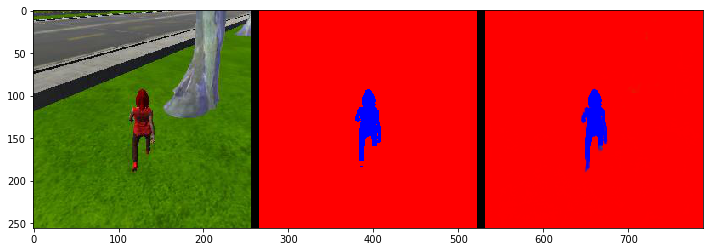

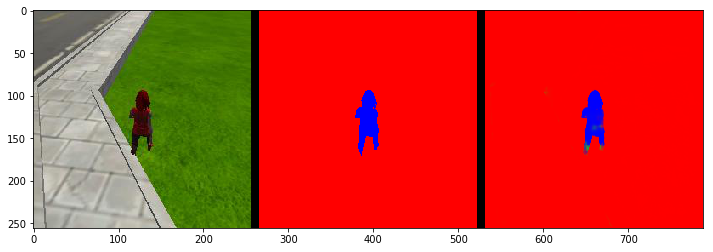

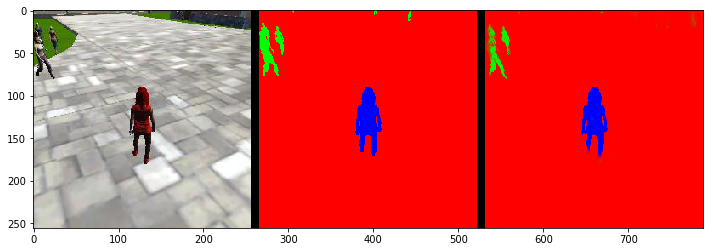

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

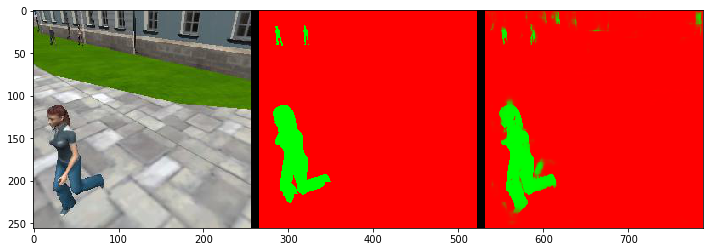

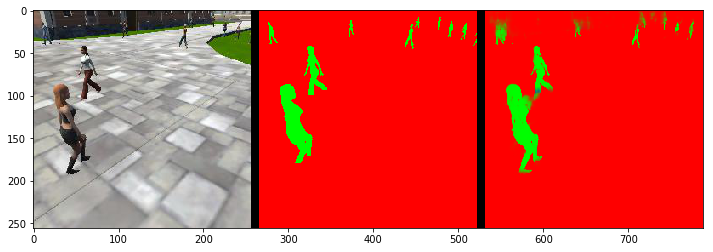

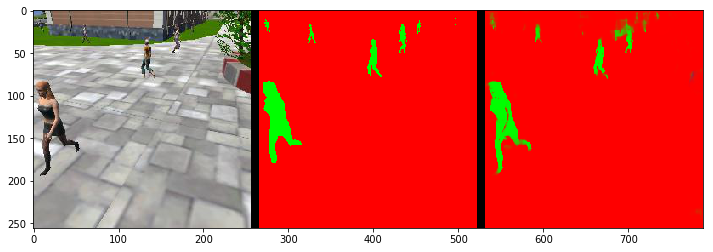

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

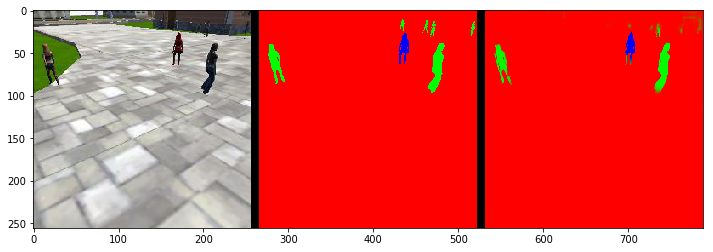

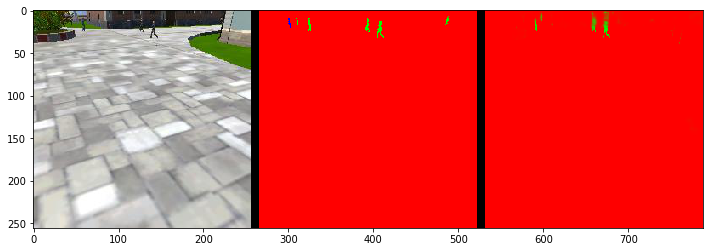

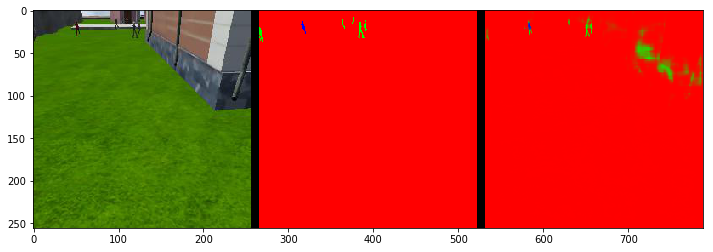

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.996658945505151
average intersection over union for other people is 0.3966179988642363
average intersection over union for the hero is 0.9264632398477664
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9890380650367778
average intersection over union for other people is 0.7842537199282269
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 69, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9965692005528324
average intersection over union for other people is 0.48865190437583333
average intersection over union for the hero is 0.31289017763765664
number true positives: 177, number false positives: 1, number false negatives: 135


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7774158523344191


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.619676708743


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.481746496699
